<a href="https://colab.research.google.com/github/sean-otoole/HODD/blob/main/PDTx_pipeline/PDTx_05_Validation_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!apt-get update
!apt-get install -y texlive-latex-base texlive-fonts-recommended texlive-fonts-extra texlive-latex-extra cm-super dvipng

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,245 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,683 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,387 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,944 kB]
Get:13 https://ppa.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [159]:
import os
import pandas as pd
import numpy as np

os.chdir("/content/drive/MyDrive/HODD/validation_data")

In [117]:
gwas_csv = "MONDO_0005180_associations_expo.csv"
del_csv = "perturbation_parkinsons_delete_results.csv"
over_csv = "perturbation_parkinsons_overexpress_results.csv"

gwas_df = pd.read_csv(gwas_csv, encoding = "ISO-8859-1")
del_df = pd.read_csv(del_csv, encoding = "ISO-8859-1")
over_df = pd.read_csv(over_csv, encoding = "ISO-8859-1")

In [118]:
# merge the top hits from the deletion and overexpression dfs
# this df will be the evidence accumulation df
# it will be used throughout this portion of the analysis for selecting a target to follow up on

del_sig_list = del_df[del_df['Sig']==1]['Gene_name'].tolist()
over_sig_list = over_df[over_df['Sig']==1]['Gene_name'].tolist()

union_list = list(set(del_sig_list) | set(over_sig_list))

# ranks the signficance for both screens, useful for categorization later
del_df['sig_rank_del'] = del_df['Goal_end_vs_random_pval'].rank(pct=True)
over_df['sig_rank_over'] = over_df['Goal_end_vs_random_pval'].rank(pct=True)

del_filtered = del_df[del_df['Gene_name'].isin(union_list)][['Gene_name','Shift_to_goal_end','Goal_end_FDR','Sig','sig_rank_del']]
del_filtered = del_filtered.rename(columns={"Shift_to_goal_end": "Shift_to_goal_end_del", "Goal_end_FDR": "Goal_end_FDR_del","Sig": "Sig_del"})

over_filtered = over_df[over_df['Gene_name'].isin(union_list)][['Gene_name','Shift_to_goal_end','Goal_end_FDR','Sig','sig_rank_over']]
over_filtered = over_filtered.rename(columns={"Shift_to_goal_end": "Shift_to_goal_end_over", "Goal_end_FDR": "Goal_end_FDR_over","Sig": "Sig_over"})

target_evidence_df = pd.merge(del_filtered, over_filtered, on='Gene_name')

In [119]:
target_evidence_df

,Gene_name,Shift_to_goal_end_del,Goal_end_FDR_del,Sig_del,sig_rank_del,Shift_to_goal_end_over,Goal_end_FDR_over,Sig_over,sig_rank_over
0,HSP90AA1,0.140043,5.730000e-114,1,0.000137,-0.093749,4.200000e-56,1,0.000479
1,MT-ND4,0.089671,5.810000e-117,1,0.000068,-0.067334,4.750000e-72,1,0.000274
2,HSP90AB1,0.062161,2.270000e-62,1,0.000274,-0.107297,2.090000e-77,1,0.000205
3,CRYAB,0.051508,2.930000e-25,1,0.000821,0.006732,1.036225e-03,1,0.048957
4,PNISR,0.050882,2.710000e-79,1,0.000205,0.036428,9.050000e-60,1,0.000410
...,...,...,...,...,...,...,...,...,...
1796,UHRF1,-0.020320,6.460366e-01,0,0.044991,0.080989,2.813198e-02,1,0.100991
1797,C8orf34,-0.023863,7.509435e-01,0,0.079932,0.037101,3.069105e-02,1,0.103795
1798,CCDC65,-0.024150,6.237531e-02,0,0.010872,0.033148,2.810000e-07,1,0.018530
1799,TUSC3,-0.024299,8.478158e-01,0,0.255795,0.034962,8.370460e-03,1,0.075214


In [252]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import matplotlib as mpl
plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering for text


from matplotlib.lines import Line2D

# Define custom legend elements
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Sig. in both',
           markerfacecolor='green', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Sig. in one,\ntop 5% in other',
           markerfacecolor='purple', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Sig. in one screen',
           markerfacecolor='black', markersize=8)
]



def plot_goal_shifts(df, colors, x_col='Shift_to_goal_end_del', y_col='Shift_to_goal_end_over',
                             title="", font_size = 14, filename=None):

    # Set Seaborn theme (grid off)
    #sns.set(style="white", context="talk")  # Removed 'whitegrid' to disable grid
    sns.set(style="ticks", context="talk")  # 'ticks' keeps both gridlines and tick marks visible


    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.scatterplot(data=df, y=y_col, x=x_col, s=40, color=colors, edgecolor=colors, ax=ax, alpha=0.8)

    # Remove gridlines explicitly (just in case)
    ax.grid(False)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add vertical dashed line at x = 0 with further apart dashes
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1,
               dashes=(10, 5))  # Adjust (10, 5) for larger spacing between dashes

    # Add horizontal dashed line as wel
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1,
               dashes=(10, 5))

    ax.set_xticks([-0.15, 0, 0.15])
    ax.set_yticks([-0.15, 0, 0.15])

    # Set consistent font size
    label_fontsize = 12

    ax.set_xlim(-0.17,0.17)
    ax.set_ylim(-0.17,0.17)

    # set a log scale

    # # Apply log scale to both axes
    # ax.set_xscale('symlog', linthresh=0.05)
    # ax.set_yscale('symlog', linthresh=0.05)

    # Apply consistent font sizes and colors to all axis labels and ticks
    ax.set_title(title, fontsize=font_size)
    ax.set_xlabel("Shift towards healthy state, deletion screen", fontsize=font_size)
    ax.set_ylabel("Shift towards healthy state, overexpression screen", fontsize=font_size)
    ax.tick_params(labelsize=font_size)

    ax.tick_params(axis='both', colors='black')  # Tick labels
    ax.xaxis.label.set_color('black')            # X-axis label
    ax.yaxis.label.set_color('black')            # Y-axis label

    # add quadrant labels
    # Get axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x_center = 0
    y_center = 0

    # Midpoints in each quadrant
    label_coords = {
        # 'Q1': ((xlim[1] + x_center)/2, (ylim[1] + y_center)/2),  # top-right
        'Healthy-State Enhancers': ((xlim[0] + x_center)/2, (ylim[1] + y_center)/2),  # top-left
        # 'Q3': ((xlim[0] + x_center)/2, (ylim[0] + y_center)/2),  # bottom-left
        'Healthy-State Suppressors': ((xlim[1] + x_center)/2, (ylim[0] + y_center)/2),  # bottom-right
    }

    # Add text labels
    for label, (x, y) in label_coords.items():
        ax.text(x, y, label, fontsize=font_size, color='black',
                ha='center', va='center', fontweight='bold')

    # Add the legend to the plot (top right = 'upper right')
    ax.legend(
    handles=legend_elements,
    loc='upper right',
    frameon=False,
    fontsize=font_size
)

    # Tidy layout and show
    plt.tight_layout()

    if filename:
      plt.savefig(f"{filename}.svg", format="svg")  # Save as svg

    plt.show()

In [253]:
# desfines a tier 1 feature vector, wherein a a hit is significant in both deletion and overexpression

target_evidence_df['Tier_1_pertubration_hit'] = target_evidence_df['Sig_del']+target_evidence_df['Sig_over']-1

In [254]:
# defines a tier 2 feature vector, wherein a hit is signicant in one screen and not another
# however, in the screen that was not significant, the hit falls within the top 5 percent of hits

# Tier 2 for significant deltion hits
only_sig_del_bin = abs(target_evidence_df['Tier_1_pertubration_hit']-1)*target_evidence_df['Sig_del']

sig_rank_thresh_bool_over = target_evidence_df['sig_rank_over']<0.05
sig_rank_thresh_bin_over = sig_rank_thresh_bool_over.astype(int)

tier_2_del = only_sig_del_bin * sig_rank_thresh_bin_over

print(sum(tier_2_del))

# Tier 2 for sigfinficant overexpression hits

only_sig_over_bin = abs(target_evidence_df['Tier_1_pertubration_hit']-1)*target_evidence_df['Sig_over']

sig_rank_thresh_bool_del = target_evidence_df['sig_rank_del']<0.05
sig_rank_thresh_bin_del = sig_rank_thresh_bool_del.astype(int)

tier_2_over = only_sig_over_bin * sig_rank_thresh_bin_del

print(sum(tier_2_over))

# combine into a single column and add to the target_evidence df

target_evidence_df['Tier_2_pertubration_hit'] = tier_2_del + tier_2_over

# establish color vector for the scatter plot

colors = np.full(len(target_evidence_df), 'black', dtype=object)  # allow full strings

colors[target_evidence_df['Tier_1_pertubration_hit'] == 1] = 'green'
colors[target_evidence_df['Tier_2_pertubration_hit'] == 1] = 'purple'

0
178


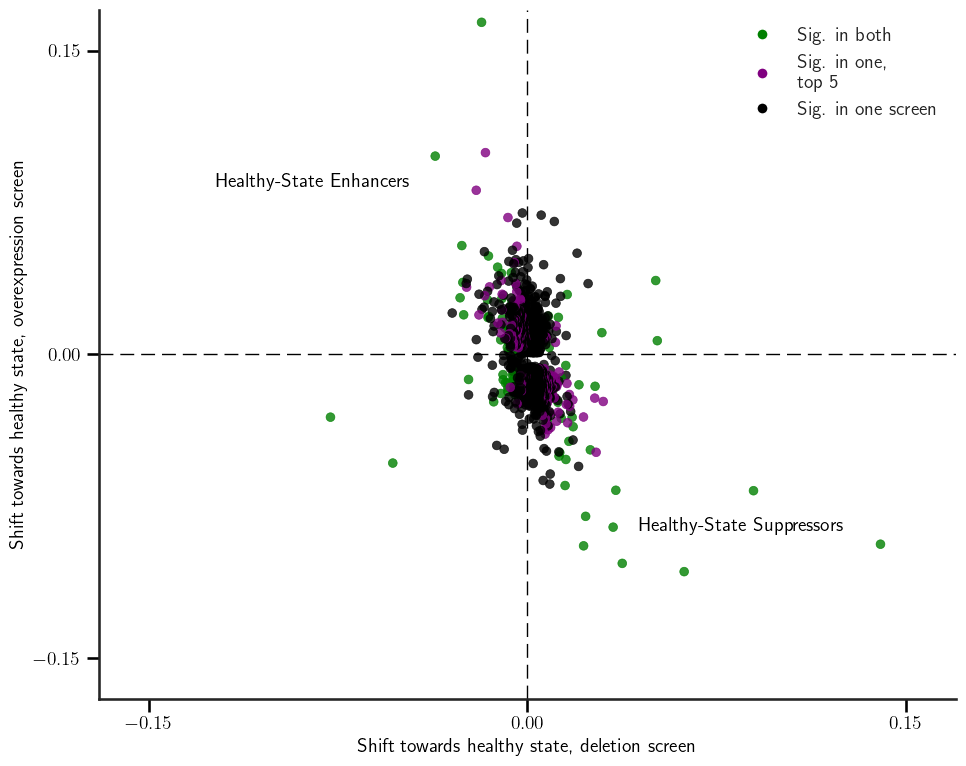

In [255]:
plot_goal_shifts(target_evidence_df, colors)

In [256]:
target_evidence_df

,Gene_name,Shift_to_goal_end_del,Goal_end_FDR_del,Sig_del,sig_rank_del,Shift_to_goal_end_over,Goal_end_FDR_over,Sig_over,sig_rank_over,Tier_1_pertubration_hit,Tier_2_pertubration_hit
0,HSP90AA1,0.140043,5.730000e-114,1,0.000137,-0.093749,4.200000e-56,1,0.000479,1,0
1,MT-ND4,0.089671,5.810000e-117,1,0.000068,-0.067334,4.750000e-72,1,0.000274,1,0
2,HSP90AB1,0.062161,2.270000e-62,1,0.000274,-0.107297,2.090000e-77,1,0.000205,1,0
3,CRYAB,0.051508,2.930000e-25,1,0.000821,0.006732,1.036225e-03,1,0.048957,1,0
4,PNISR,0.050882,2.710000e-79,1,0.000205,0.036428,9.050000e-60,1,0.000410,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1796,UHRF1,-0.020320,6.460366e-01,0,0.044991,0.080989,2.813198e-02,1,0.100991,0,1
1797,C8orf34,-0.023863,7.509435e-01,0,0.079932,0.037101,3.069105e-02,1,0.103795,0,0
1798,CCDC65,-0.024150,6.237531e-02,0,0.010872,0.033148,2.810000e-07,1,0.018530,0,1
1799,TUSC3,-0.024299,8.478158e-01,0,0.255795,0.034962,8.370460e-03,1,0.075214,0,0
